In [25]:
%env CUDA_VISIBLE_DEVICES=GPU-8868e167-e666-53c7-6c41-d8e83081f07e

env: CUDA_VISIBLE_DEVICES=GPU-8868e167-e666-53c7-6c41-d8e83081f07e


In [26]:
import pandas as pd

#load data
data = pd.read_csv(r"/home/lero/idrive/cmac/DDMAP/Stability studies/Stability_dataset_August_update.csv", na_values='nan')
data = data.drop(data.columns[0:7], axis=1)
data.drop(['Unnamed: 209', 'Unnamed: 210'], axis=1, inplace=True)

#unique_apis = data['API'].nunique()

#Store values for API/ polymer, condition
original_api = data['API']
original_polymer = data['Polymer']
original_condition = data['condition']

#fill pure api with 0 for polymer mol desc
pure = data['Polymer']=='Pure'
polymer_descriptors = data.columns[219:]
data.loc[pure, polymer_descriptors] = 0

#drop conditions since these have been split into temp/ humidity
data.drop(['condition'], axis=1, inplace=True)

#fill na values with average
data.fillna(data.mean(numeric_only=True), inplace=True)

one_week_timepoint = 168

df_less_than_one = (data['Average days stable'] <= one_week_timepoint).astype(int)

data['one_week_stability'] = df_less_than_one

#Define Features for ColumnTransformer (AFTER ALL DROPS within dataframe) ---
categorical_features = ['API', 'Polymer']
# Identify numerical features:
dont_scale_features = data.drop(['Average days stable', 'GFA', 'one_week_stability'], axis=1).columns.tolist()
numerical_features = [col for col in dont_scale_features if col not in categorical_features]

data.drop(['API', 'Polymer'], inplace=True, axis=1)

unstable = data['one_week_stability'].value_counts()

data
#print(unique_apis)

Average days stable  Drug loading (wt%)  GFA  Tm (°C)  Tg (°C)  \
0             2160.000000                  60  2.0    166.0     25.2   
1             2160.000000                  50  2.0    166.0     25.2   
2             2160.000000                  40  2.0    166.0     25.2   
3             2160.000000                  30  2.0    166.0     25.2   
4             2160.000000                  20  2.0    166.0     25.2   
...                   ...                 ...  ...      ...      ...   
4603            34.105278                  20  2.0    123.0     -7.0   
4604            32.881528                  70  2.0    123.0     -7.0   
4605            30.450139                  50  2.0    123.0     -7.0   
4606             2.438472                  80  2.0    123.0     -7.0   
4607             0.000000                  70  2.0    123.0     -7.0   

      ΔHfus (kJ mol–1)  ΔSfus × 10–2 (kJ mol–1 K–1)  Unnamed: 0  \
0            39.272748                     7.892092          66   
1            39.272748                     7.892092          66   
2            39.272748                     7.892092          66   
3            39.272748                     7.892092          66   
4            39.272748                     7.892092          66   
...                ...                          ...         ...   
4603         35.854005                     6.891436          70   
4604         35.854005                     6.891436          70   
4605         35.854005                     6.891436          70   
4606         35.854005                     6.891436          70   
4607         35.854005                     6.891436          70   

      MaxAbsEStateIndex_x  MaxEStateIndex_x  ...  fr_term_acetylene_y  \
0               10.524469         10.524469  ...                  0.0   
1               10.524469         10.524469  ...                  0.0   
2               10.524469         10.524469  ...                  0.0   
3               10.524469         10.524469  ...                  0.0   
4               10.524469         10.524469  ...                  0.0   
...                   ...               ...  ...                  ...   
4603             0.036252         11.283357  ...                  0.0   
4604             0.036252         11.283357  ...                  0.0   
4605             0.036252         11.283357  ...                  0.0   
4606             0.036252         11.283357  ...                  0.0   
4607             0.036252         11.283357  ...                  0.0   

      fr_tetrazole_y  fr_thiazole_y  fr_thiocyan_y  fr_thiophene_y  \
0                0.0            0.0            0.0             0.0   
1                0.0            0.0            0.0             0.0   
2                0.0            0.0            0.0             0.0   
3                0.0            0.0            0.0             0.0   
4                0.0            0.0            0.0             0.0   
...              ...            ...            ...             ...   
4603             0.0            0.0            0.0             0.0   
4604             0.0            0.0            0.0             0.0   
4605             0.0            0.0            0.0             0.0   
4606             0.0            0.0            0.0             0.0   
4607             0.0            0.0            0.0             0.0   

      fr_unbrch_alkane_y  fr_urea_y  Temperature  Humidity  one_week_stability  
0              40.000000        0.0     4.954955   4.72973                   0  
1              40.000000        0.0     4.954955   4.72973                   0  
2              40.000000        0.0     4.954955   4.72973                   0  
3              40.000000        0.0     4.954955   4.72973                   0  
4              40.000000        0.0     4.954955   4.72973                   0  
...                  ...        ...          ...       ...                 ...  
4603            0.000000        0.0     4.954955   

In [27]:
#split data
X = data.drop(['Average days stable'], axis=1)
y_non_binary = data['Average days stable']
y = (y_non_binary>=2160).astype(int)

In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models = {
    # 'Logistic Regression': (
    #     LogisticRegression(max_iter=100000),  
    #     {  
    #         'model__C': np.logspace(-4, 4, 20),
    #         'model__penalty': ['l2'], 
    #         'model__solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
    #     }
    # ),
    # 'Linear SVC': (
    #     LinearSVC(max_iter=100000),
    #     {
    #         'model__C': [0.01, 0.1, 1, 10, 100]  
    #     }
    # ),
    # 'K Neighbors Classifier': (
    #     KNeighborsClassifier(), 
    #     {
    #         'model__n_neighbors': np.arange(2,30,1)
    #     }
    # ),
    # 'Decision Tree Classifier': (
    #     DecisionTreeClassifier(), 
    #     {
    #         'model__criterion': ['gini', 'entropy'],
    #         'model__max_depth': [None, 10, 20, 30],
    #         'model__min_samples_split': [2, 5, 10],
    #         'model__min_samples_leaf': [1, 2, 4]
    #     }
    # ),
    'Random Forest Classifier': (
        RandomForestClassifier(random_state=42), 
        {
            'model__n_estimators': [300, 500, 800],
            'model__max_features': ['sqrt', 'log2', None],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 4, 6]
        }
    ),
    'XGBoost classifier': (
        XGBClassifier(random_state=42),
        {
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.5, 0.7, 0.9, 1],
            'model__colsample_bytree': [0.5, 0.7, 0.9, 1],
            'model__learning_rate': [0.001, 0.01, 0.1, 0.2],
            'model__n_estimators': [300, 500, 800],
        }
    ),
    # 'MLP Classifier': (
    #     MLPClassifier(max_iter=10000), 
    #     {
    #         'model__hidden_layer_sizes': [(50,), (100,), (50, 30)],
    #         'model__alpha': [0.0001, 0.001, 0.01],
    #         'model__solver': ['sgd', 'adam']
    #     }
    # )
}

In [29]:
#pre-processor for one-hot encoding and scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), numerical_features)
    ],
    remainder = 'passthrough' # Keep any other columns not explicitly transformed (e.g., if there are any not in num or cat)
)

In [21]:
#Nested cv
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, GroupKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import f1_score
import os

results = {}
scorer = make_scorer(f1_score, average='binary')

#groups for GroupKFold
groups = (original_api.astype(str)).values

#GroupKFold for outer cv
outer_cv = GroupKFold(n_splits=5) #change n_splits to 80:20
inner_cv = GroupKFold(n_splits=5) #change n_splits to 80:20

#directory to save the models
save_directory = '/home/lero/idrive/cmac/DDMAP/Stability studies/Model_results/Classifier/July_api_no'
os.makedirs(save_directory, exist_ok=True)

for model_name, (classifier, param_grid) in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', classifier)
    ])
    
    print('Model:', model_name)
  
    # Perform nested cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring=scorer, verbose=2, n_jobs=64)
    
    fit_params = {'groups': groups}
    
    # Evaluate outer loop scores
    nested_score = cross_val_score(grid_search, X, y, groups=groups, cv=outer_cv, params=fit_params, n_jobs=64)
    
    # Get predictions
    predictions = cross_val_predict(grid_search, X, y, groups=groups, cv=outer_cv, params=fit_params, method='predict', n_jobs=64)

    # Fit to find best parameters, though typically this would be done differently to maintain a holdout test set 
    grid_search.fit(X, y, **fit_params)
    best_params = grid_search.best_params_
    
    # Save the best model
    best_model = grid_search.best_estimator_
    model_file_path = os.path.join(save_directory, f'{model_name}_best_model.pkl')
    with open(model_file_path, 'wb') as model_file:
        pickle.dump(best_model, model_file)

    results[model_name] = {
        'nested_score': nested_score,
        'ground_truth': y.values,
        'predictions': predictions,
        'best_params': best_params
    }

dictionary_file_path = os.path.join(save_directory, 'Classifiers_results_dictionary.pkl')   
with open(dictionary_file_path, 'wb') as f:
    pickle.dump(results, f)
    
print('Finito')


Model: Random Forest Classifier
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=6, model__n_estimators=300; total time=  30.3s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_split=2, model__n_estimators=300; total time=  30.4s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=6, model__n_estimators=300; total time=  31.1s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=300; total time=  31.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=6, model__n_estimators=300; total time=  31.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=4, model__n_estimators=300; total time=  32.2s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=4, model__n_estimators=300; total time=  3

In [30]:
# + tags=[]
#model scoring
import pickle
import pandas as pd
import numpy as np
import os

with open('/home/lero/idrive/cmac/DDMAP/Stability studies/Model_results/Classifier/July_api_no/Classifiers_results_dictionary.pkl', 'rb') as f:
    results = pickle.load(f)
    
records = []

for model in results:
    score = results[model]['nested_score']
    mean_score = np.mean(score)
    records.append({'Model': model, 'Score': mean_score})
    
results_df = pd.DataFrame(records)
results_pivot = results_df.pivot(columns='Model', values='Score')
results_df

Model     Score
0  Random Forest Classifier  0.851976
1        XGBoost classifier  0.877539

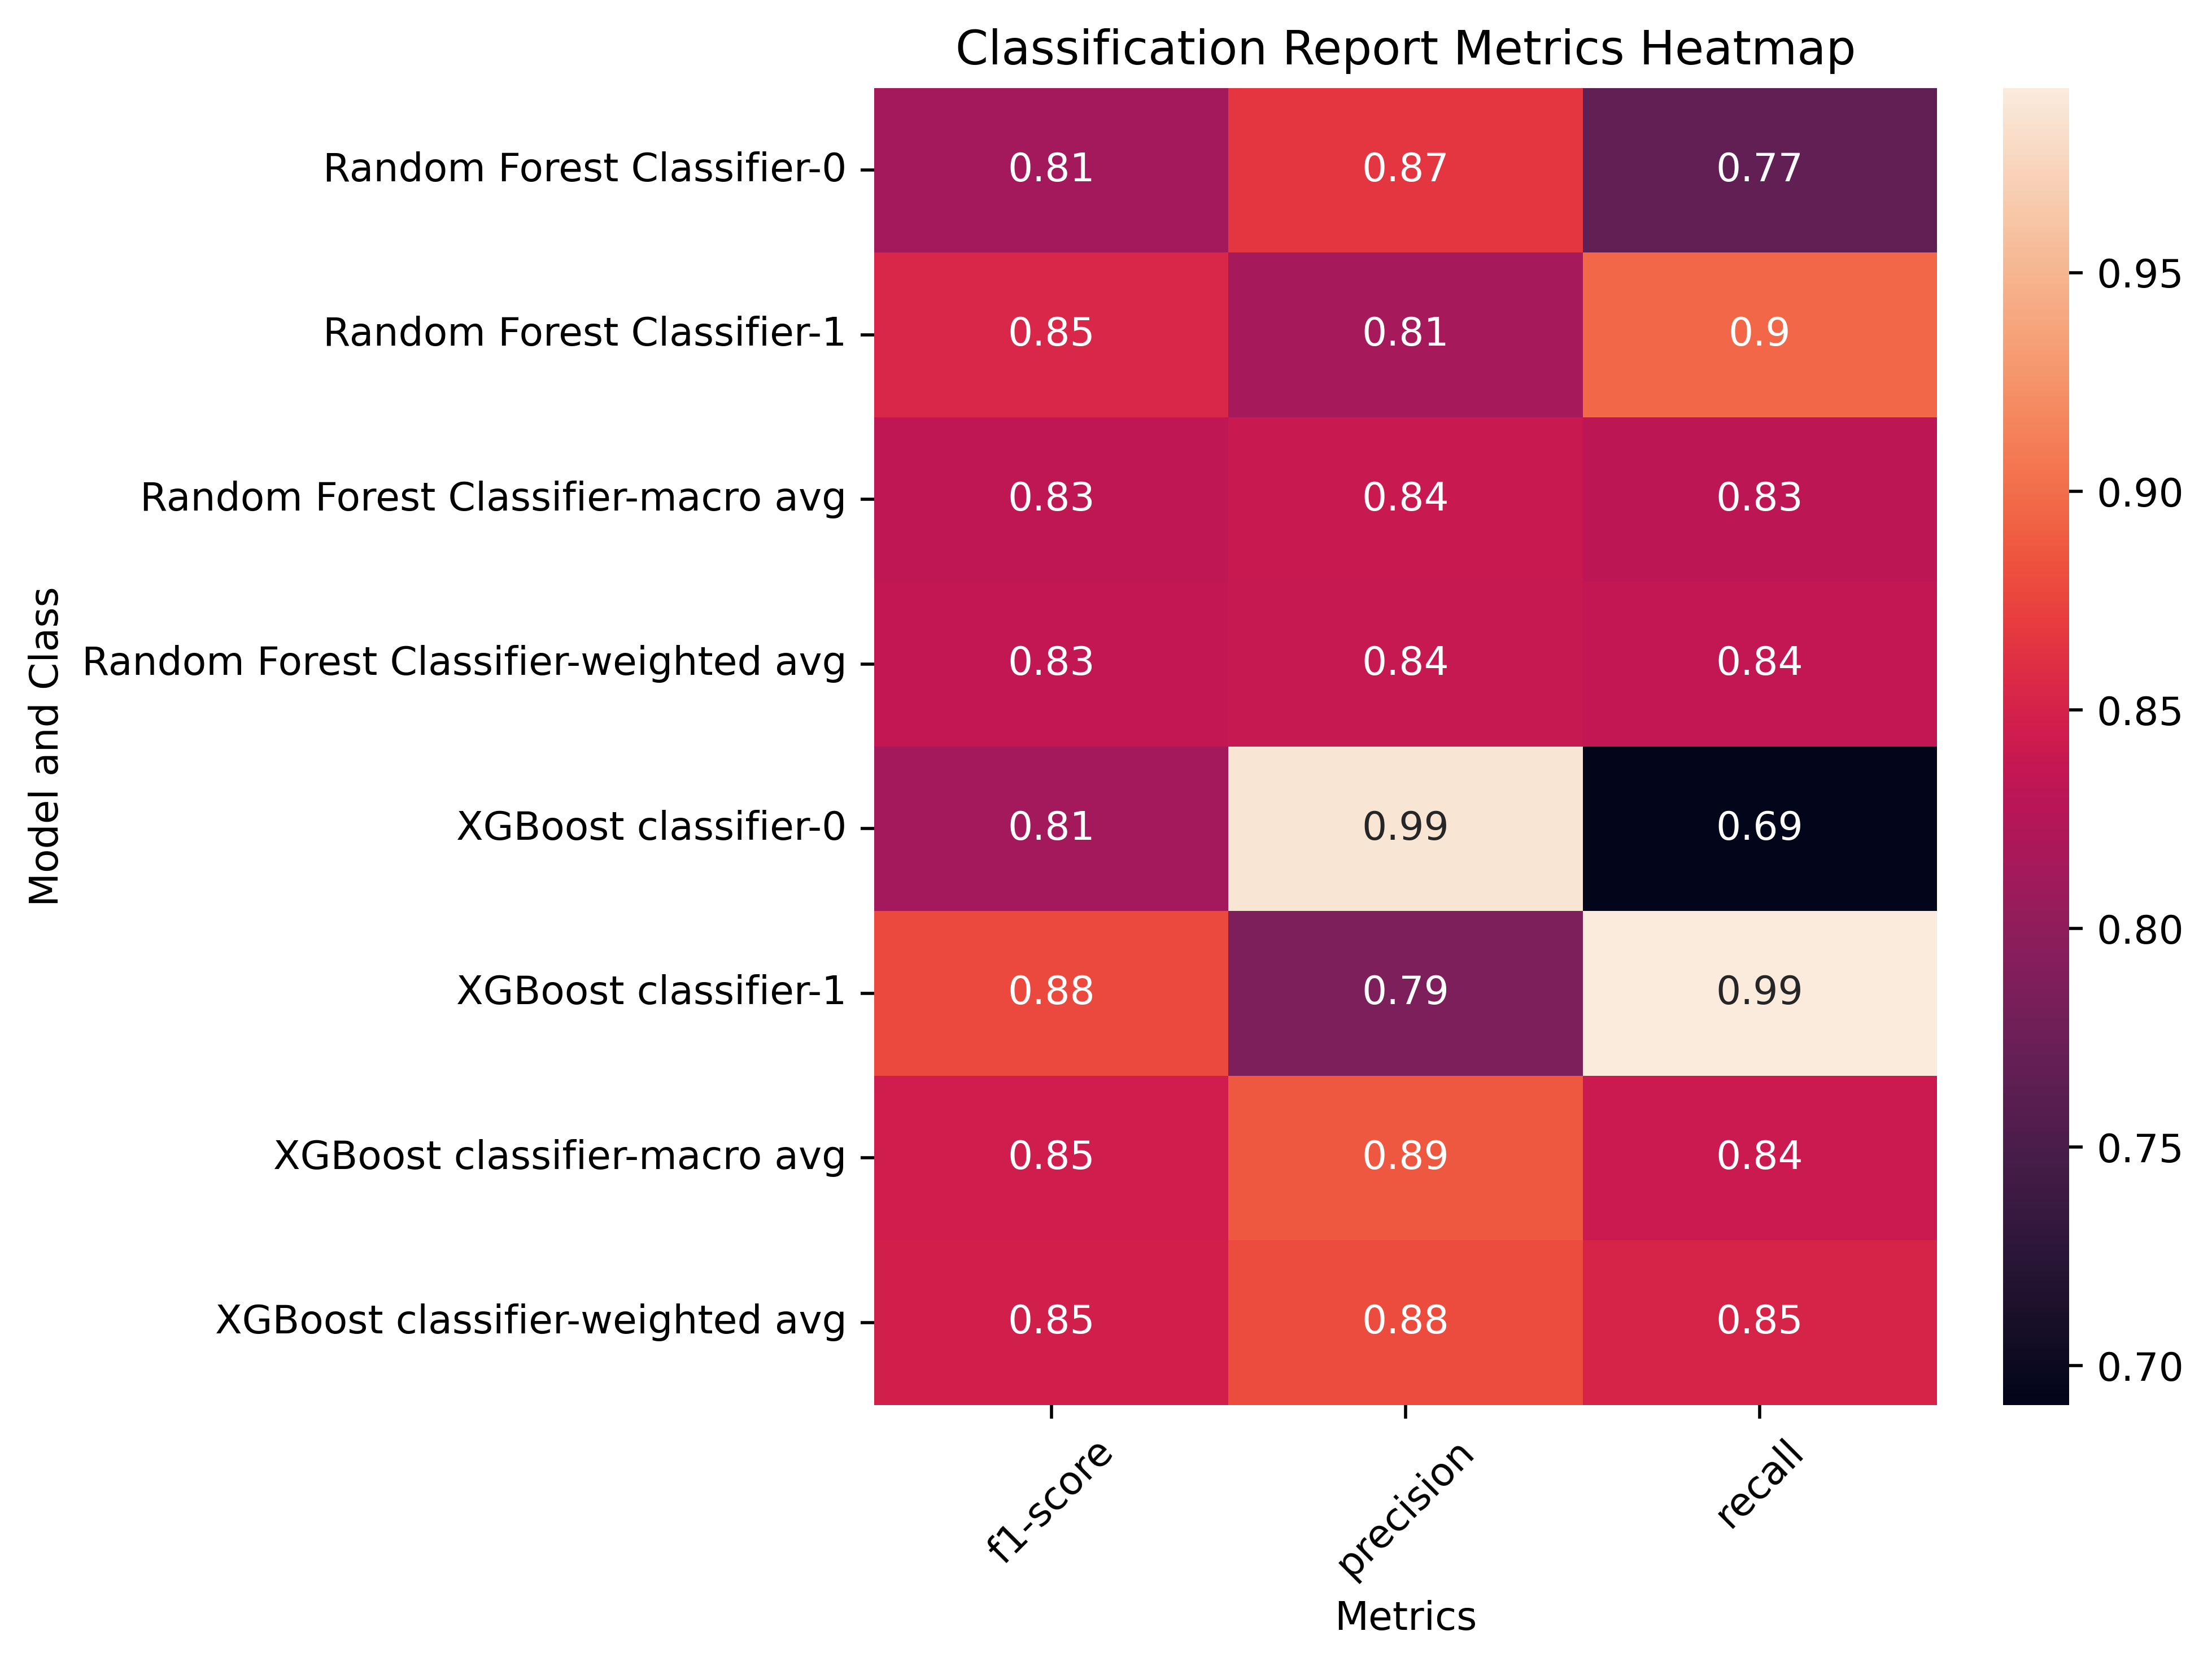

Metric                                 f1-score  precision    recall
Model                    Class                                      
Random Forest Classifier 0             0.812948   0.865334  0.766542
                         1             0.853550   0.814924  0.896019
                         macro avg     0.833249   0.840129  0.831281
                         weighted avg  0.834641   0.838401  0.835720
XGBoost classifier       0             0.813048   0.987350  0.691053
                         1             0.877514   0.786542  0.992283
                         macro avg     0.845281   0.886946  0.841668
                         weighted avg  0.847492   0.880061  0.851997


In [31]:
#Visualise model scores
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List to hold each report entry as a dictionary
reports_list = []

for model in results:
    # Obtain the classification report as a dictionary
    report = classification_report(results[model]['ground_truth'], 
                                   results[model]['predictions'], 
                                   output_dict=True, 
                                   digits=2)
    
    # Flatten the dictionary and add to reports_list
    for class_label, metrics in report.items():
        if isinstance(metrics, dict):  # Ignore the 'accuracy' mean metrics lines
            for metric_name, metric_value in metrics.items():
                reports_list.append({
                    "Model": model,
                    "Class": class_label,
                    "Metric": metric_name,
                    "Value": metric_value
                })

# Convert the list of dictionaries into a DataFrame
reports_df = pd.DataFrame(reports_list)

# Create pivot table to organize data better
pivot_table = reports_df.pivot_table(index=['Model', 'Class'], 
                                     columns='Metric', 
                                     values='Value')

pivot_table.drop(columns='support', inplace=True)

plt.figure(figsize = (8,6), dpi=500)
sns.heatmap(pivot_table, annot = True)
plt.title('Classification Report Metrics Heatmap')
plt.xlabel('Metrics')
plt.xticks(rotation =45)
plt.ylabel('Model and Class')
plt.tight_layout()
#save_directory = '/projects/cp/se_users/ksrn200/Classifier/GroupKFold/Plots/One_week_stability'
#plot_filename = os.path.join(save_directory, 'classification_report.png')
#plt.savefig(plot_filename)

plt.show()

# Display the pivot table
print(pivot_table)

Random Forest Classifier
[[1645  501]
 [ 256 2206]]
              precision    recall  f1-score   support

           0       0.87      0.77      0.81      2146
           1       0.81      0.90      0.85      2462

    accuracy                           0.84      4608
   macro avg       0.84      0.83      0.83      4608
weighted avg       0.84      0.84      0.83      4608



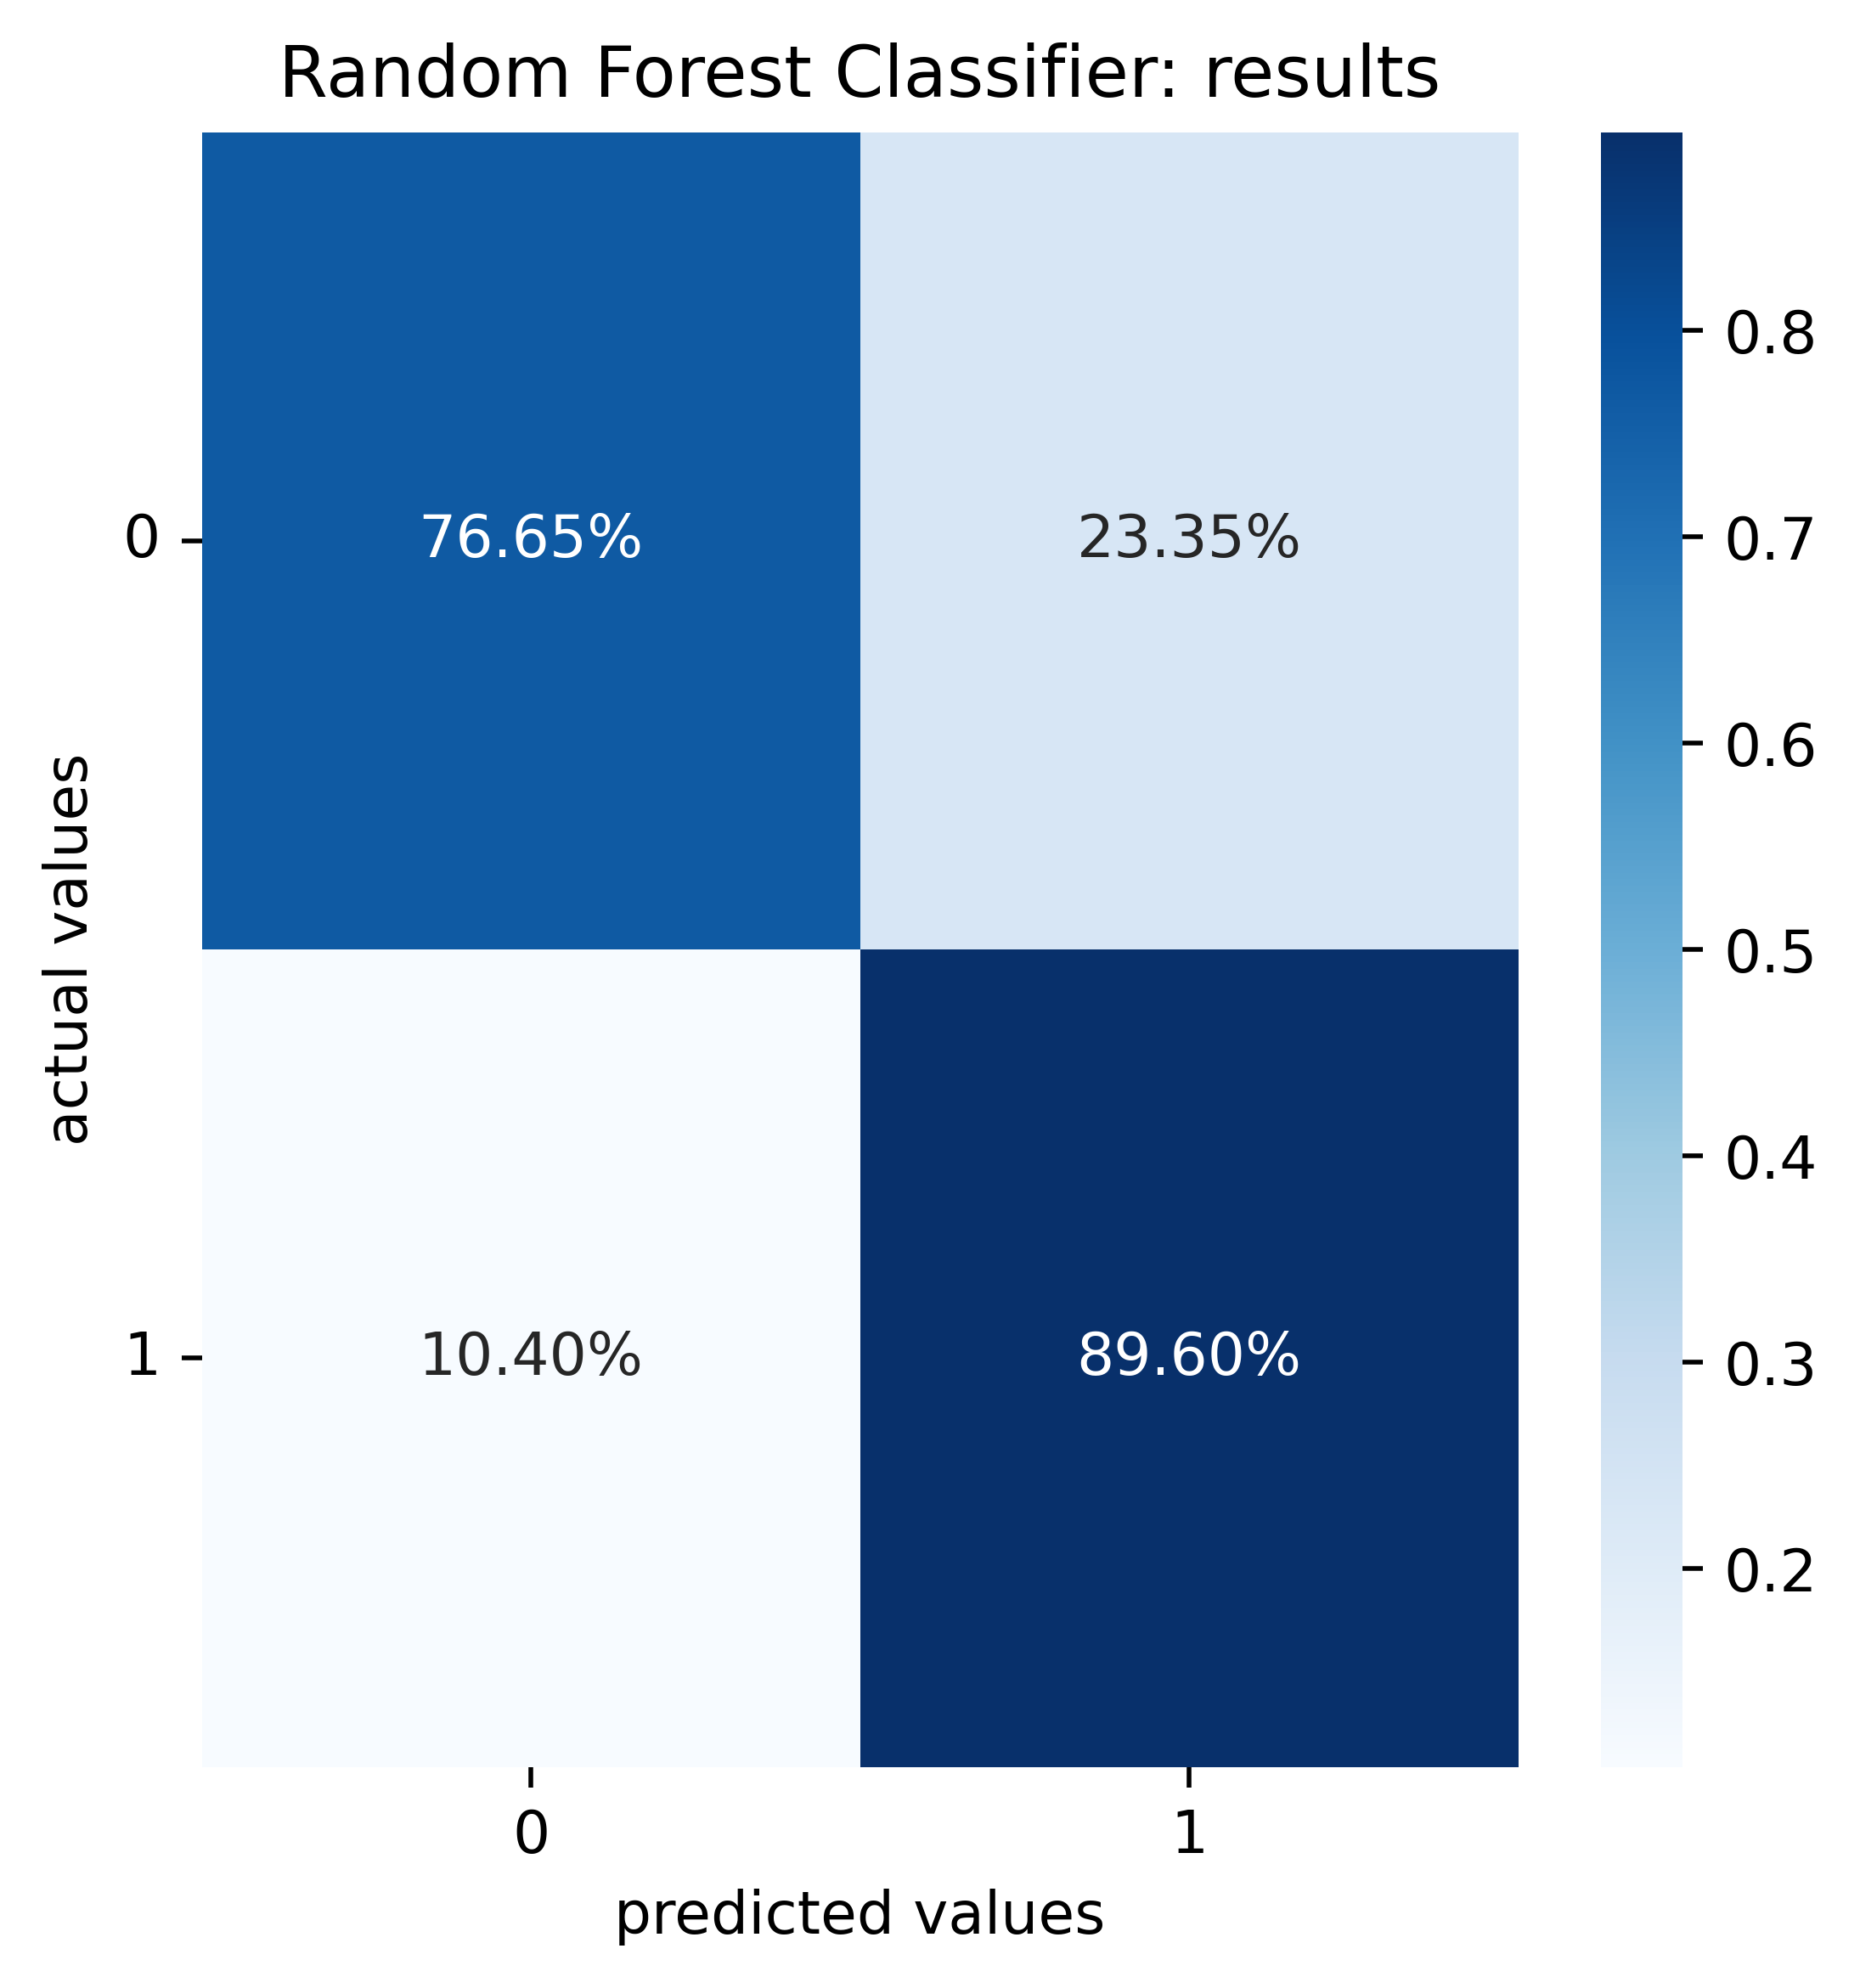

XGBoost classifier
[[1483  663]
 [  19 2443]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      2146
           1       0.79      0.99      0.88      2462

    accuracy                           0.85      4608
   macro avg       0.89      0.84      0.85      4608
weighted avg       0.88      0.85      0.85      4608



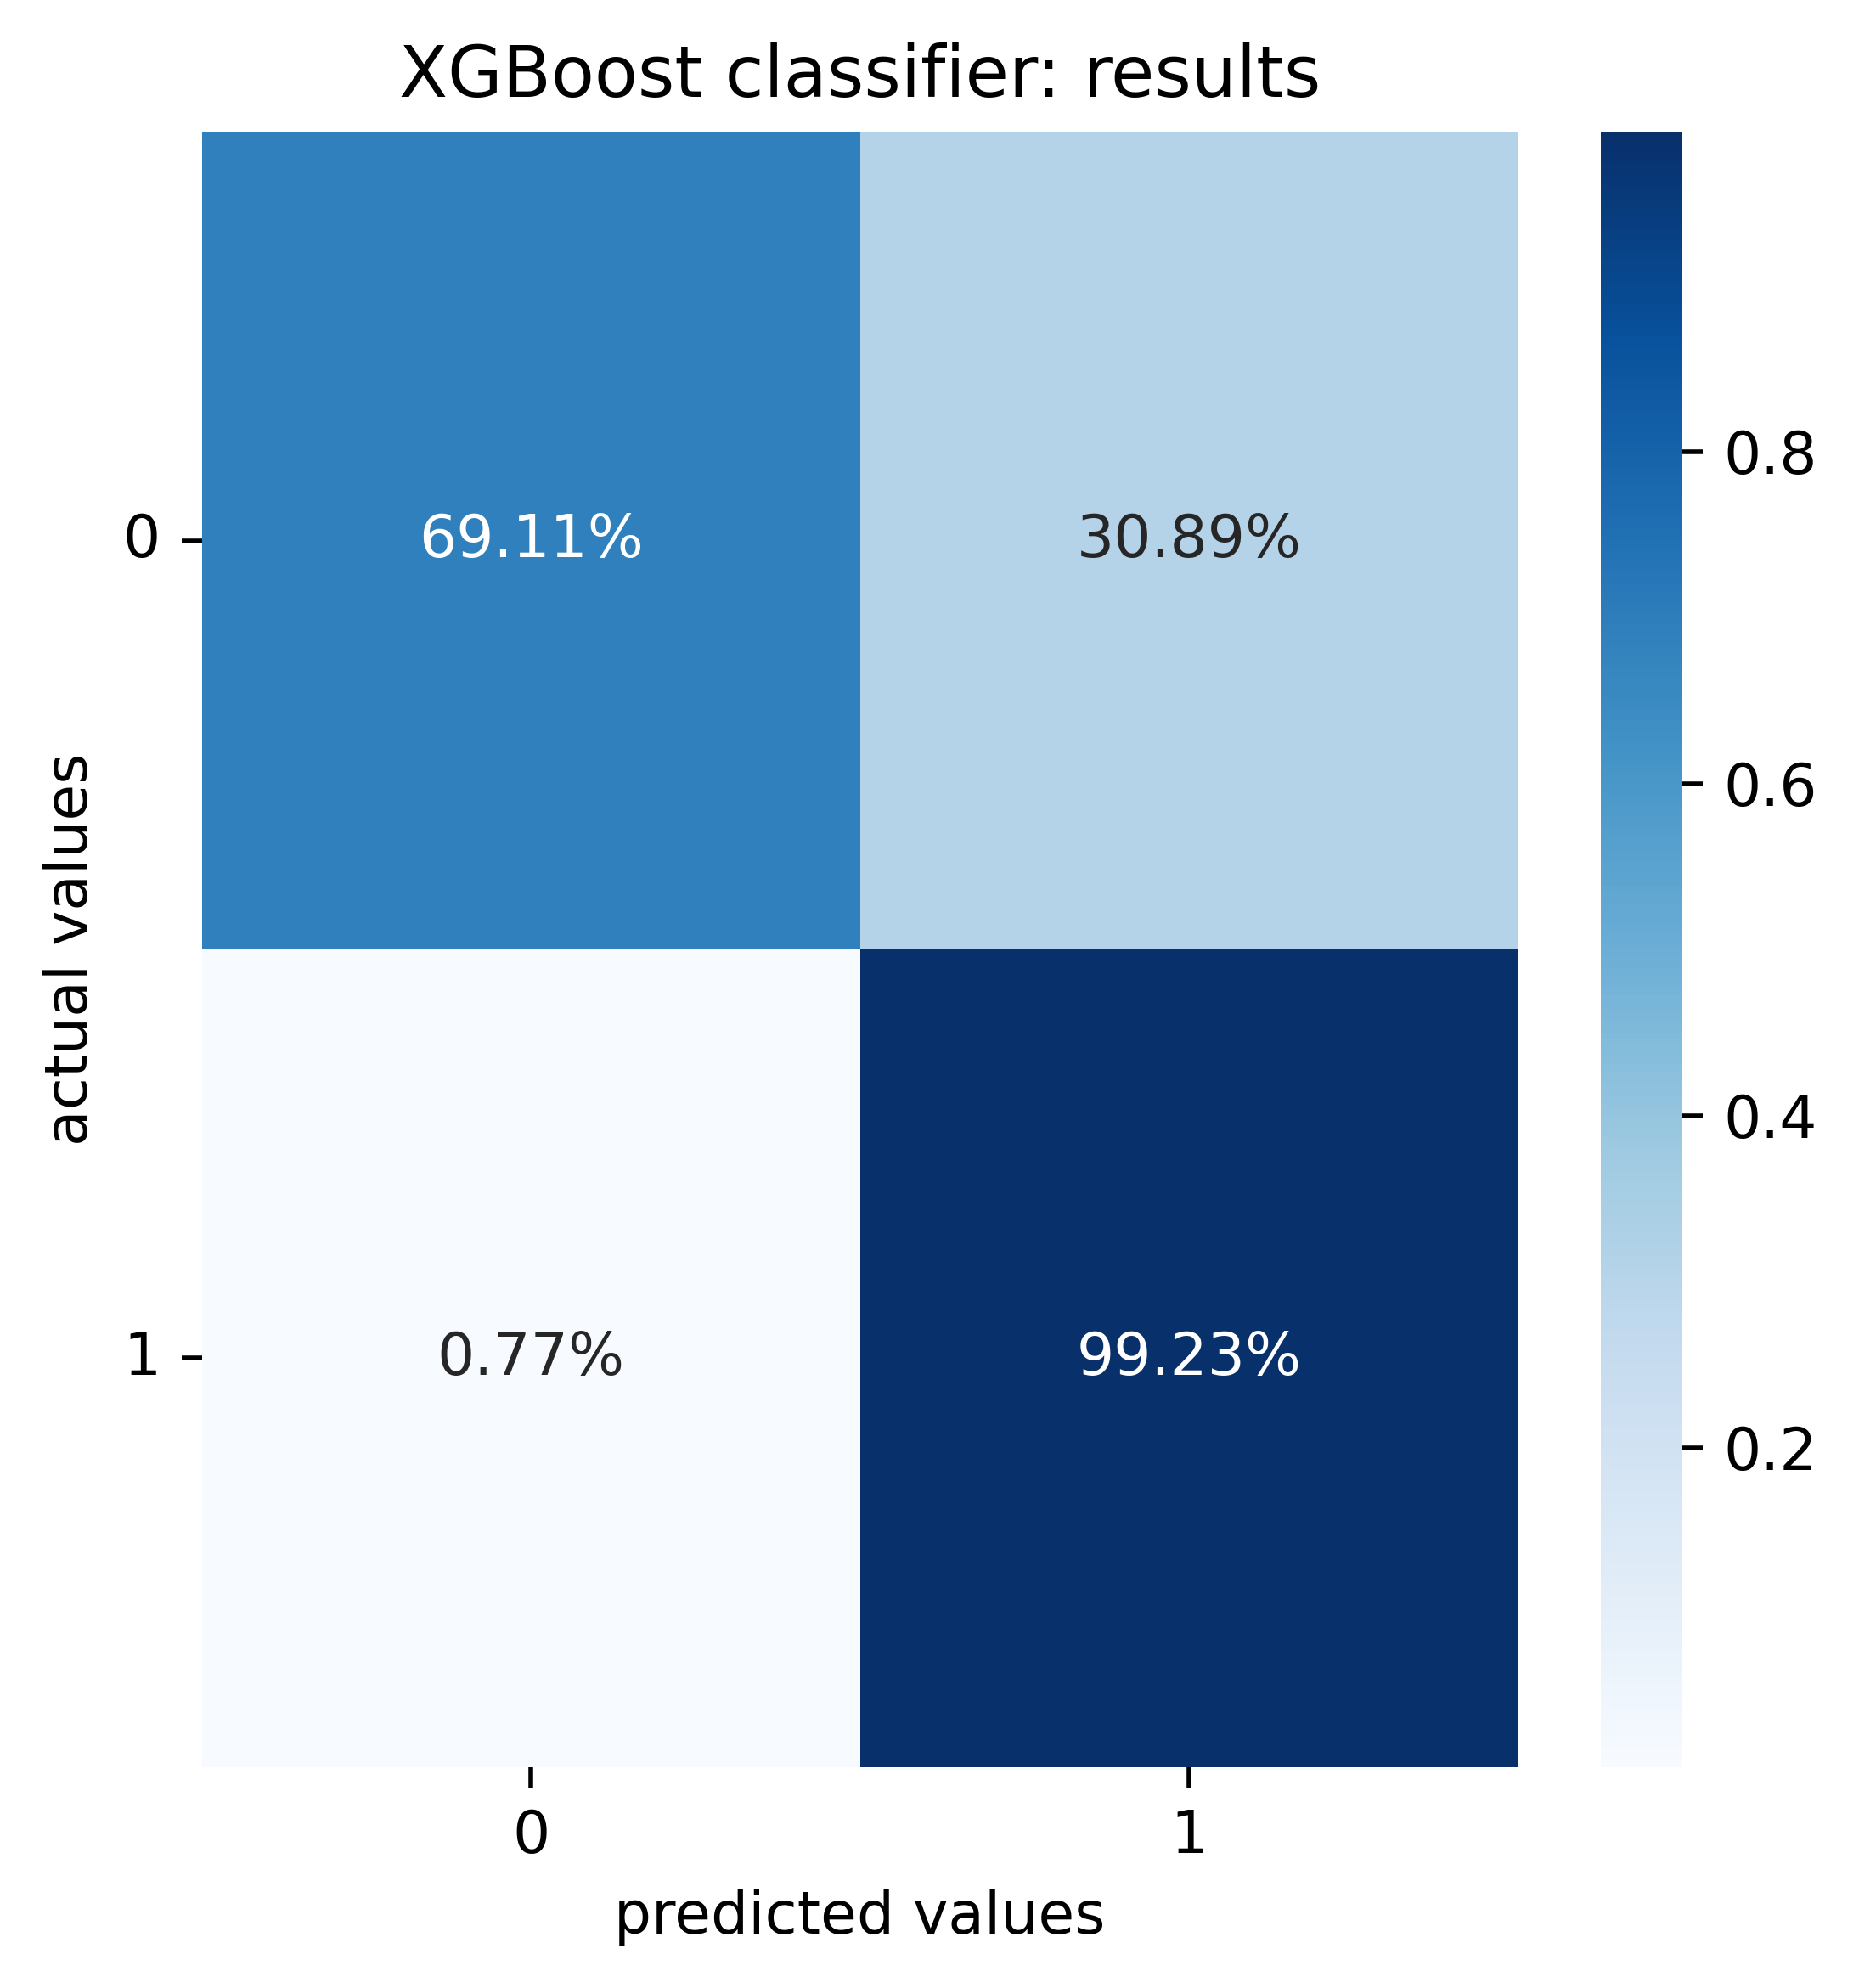

In [33]:
#visualisation of model performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import os


for model in results:
    print(model)
    cf_matrix = confusion_matrix(results[model]['ground_truth'], results[model]['predictions'])
    print(cf_matrix)
    print(classification_report(results[model]['ground_truth'], results[model]['predictions'], digits=2))
    plt.figure(figsize=(5,5), dpi=500)
    plt.title(f'{model}: results')
    sns.heatmap(normalize(cf_matrix, axis=1, norm='l1'), annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'], fontsize=10, rotation=0)
    plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], fontsize=10, rotation=0)
    
    save_directory = '/home/lero/idrive/cmac/DDMAP/Stability studies/Model_results'
    plot_filename = os.path.join(save_directory, f'{model}_results.png')
    plt.savefig(plot_filename)
    
    plt.show()


                feature  Importance
427  one_week_stability    0.711781
0    Drug loading (wt%)    0.071218
32           BalabanJ_x    0.023533
127         RingCount_x    0.005295
66           SMR_VSA1_x    0.004930
102       VSA_EState2_x    0.004352
30        BCUT2D_MRHI_x    0.004288
103       VSA_EState3_x    0.003737
3               Tg (°C)    0.003445
97        EState_VSA7_x    0.003409


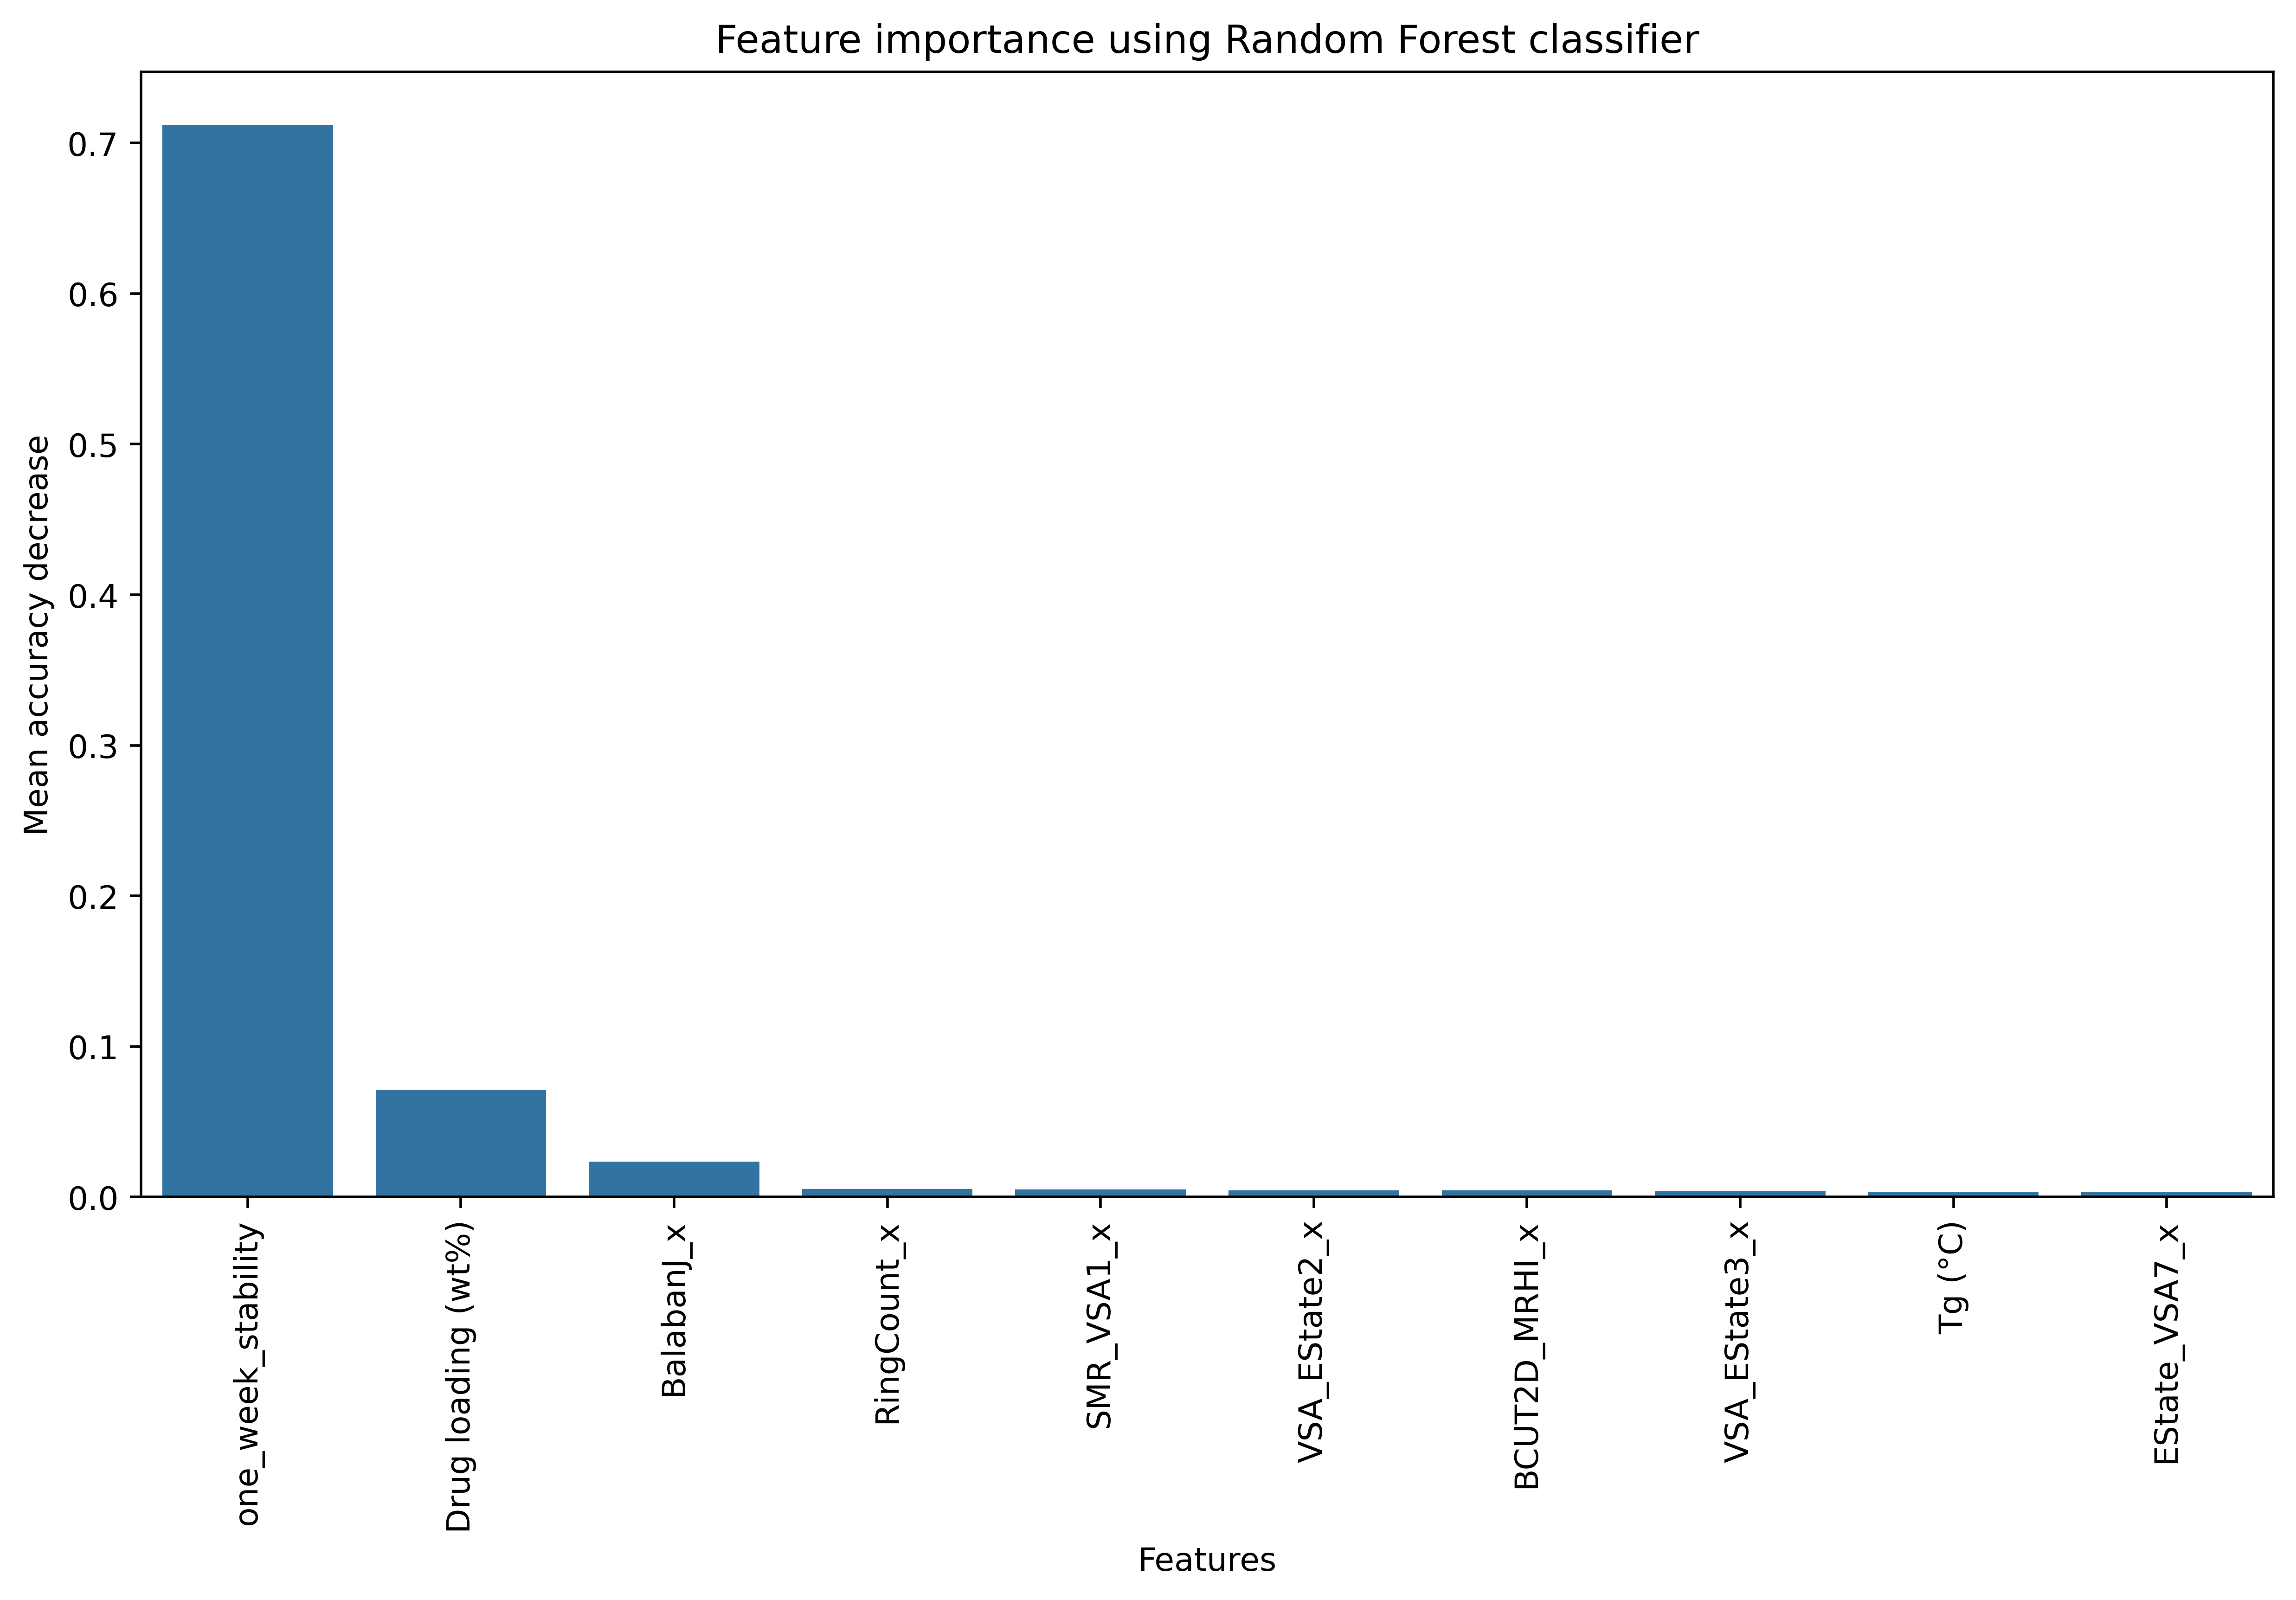

In [40]:
#parameters of importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model pipeline
with open('/home/lero/idrive/cmac/DDMAP/Stability studies/Model_results/Classifier/July_api_no/Random Forest Classifier_best_model.pkl', 'rb') as f:
    pipeline = pickle.load(f)
    
# Transform the features
X_transformed = pipeline.named_steps['preprocessor'].transform(X)

model = pipeline.named_steps['model']

importances = model.feature_importances_

feature_names = X.columns

importance_df = pd.DataFrame({'feature': feature_names, 'Importance': importances})
importance_df.sort_values(by = 'Importance', inplace=True, ascending=False)
top_parameters = importance_df.iloc[:10]
print(top_parameters)

plt.figure(figsize=(10,7), dpi=500)
sns.barplot(top_parameters, x='feature', y='Importance')
plt.title('Feature importance using Random Forest classifier')
plt.xticks(rotation =90)
plt.xlabel('Features')
plt.ylabel('Mean accuracy decrease')
plt.tight_layout()
save_directory = '/home/lero/idrive/cmac/DDMAP/Stability studies/Model_results'
plot_filename = os.path.join(save_directory, 'Randon_forest_classifier_feature_importance.png')
plt.savefig(plot_filename)
plt.show()
